In [ ]:
!pip install transformers@git+https://github.com/monuminu/transformers.git
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/monuminu/transformers.git to /tmp/pip-install-jkp_ta85/transformers_23d46214d32047d09c5f88bdbf5be7dc
  Running command git clone -q https://github.com/monuminu/transformers.git /tmp/pip-install-jkp_ta85/transformers_23d46214d32047d09c5f88bdbf5be7dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-jkp_ta85/detectron2_a36d4205cd534c6e88b4da3cb2074c27
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-jkp_ta85/detectron2_a36d4205cd534c6e88b4da3cb2074c27
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyyaml>=5.1

In [ ]:
# !pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
# !pip install torch -f https://download.pytorch.org/whl/rocm4.0.1/torch_stable.html
# !pip install ninja
# !pip install 'git+https://github.com/pytorch/vision.git@v0.9.0'
import torch
print(torch.__version__)

1.12.0+cu113


In [ ]:
import numpy as np
import os
import numpy as np
import pandas as pd
import torch
import warnings
import tensorflow as tf
from transformers import LayoutLMv2Tokenizer, LayoutLMv2ForTokenClassification, LayoutLMv2Config
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import ImageDraw, ImageFont, Image

def get_availables_gpus():
  if tf.config.experimental.list_physical_devices('GPU'):
    return 'cuda'
  else: return 'cpu'
  
device = get_availables_gpus()
warnings.filterwarnings('ignore')

def normalize_box(box, width, height):
    width = int(width)
    height = int(height)
    return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def de_normalize(box, width, height):
  return [
          int((width * box[0])/1000),
          int((height * box[1])/1000),
          int((width * box[2])/1000),
          int((height * box[3])/1000)
  ]

def resize_and_align_bounding_box(bbox, original_image, target_size):
    x_, y_ = original_image.size
    x_scale = target_size / x_ 
    y_scale = target_size / y_
    origLeft, origTop, origRight, origBottom = tuple(bbox)
    x = int(np.round(origLeft * x_scale))
    y = int(np.round(origTop * y_scale))
    xmax = int(np.round(origRight * x_scale))
    ymax = int(np.round(origBottom * y_scale)) 
    return [x-0.5, y-0.5, xmax+0.5, ymax+0.5]
 
class InvoiceDataSet(Dataset):
    """LayoutLM dataset with visual features."""
 
    def __init__(self, df, tokenizer, max_length, target_size, train=True):
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_length = max_length
        self.target_size = target_size
        self.pad_token_box = [0, 0, 0, 0]
        self.train = train
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx,:].to_dict()        
        #base_path = data_config.base_image_path
        original_image = Image.open(os.path.join(base_path , item["imageFilename"])).convert("RGB")
        # resize to target size (to be provided to the pre-trained backbone)
        resized_image = original_image.resize((self.target_size, self.target_size))
        print(resized_image)
        # first, read in annotations at word-level (words, bounding boxes, labels)
        words = item["words"]
        unnormalized_word_boxes = item["bbox"]
        word_labels = item["label"]
        width = item["imageWidth"]
        height = item["imageHeight"]
        normalized_word_boxes = [normalize_box(bbox, width, height) for bbox in unnormalized_word_boxes]
        assert len(words) == len(normalized_word_boxes)
 
        # next, transform to token-level (input_ids, attention_mask, token_type_ids, bbox, labels)
        token_boxes = []
        unnormalized_token_boxes = []
        token_labels = []
        for word, unnormalized_box, box, label in zip(words, unnormalized_word_boxes, normalized_word_boxes, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            unnormalized_token_boxes.extend(unnormalized_box for _ in range(len(word_tokens)))
            token_boxes.extend(box for _ in range(len(word_tokens)))
            # label first token as B-label (beginning), label all remaining tokens as I-label (inside)
            for i in range(len(word_tokens)):
                if  1 == 1:#i == 0:
                    token_labels.extend(['B-' + label])
                else:
                    token_labels.extend(['I-' + label])
        
        # Truncation of token_boxes + token_labels
        special_tokens_count = 2 
        if len(token_boxes) > self.max_seq_length - special_tokens_count:
            token_boxes = token_boxes[: (self.max_seq_length - special_tokens_count)]
            unnormalized_token_boxes = unnormalized_token_boxes[: (self.max_seq_length - special_tokens_count)]
            token_labels = token_labels[: (self.max_seq_length - special_tokens_count)]
        
        # add bounding boxes and labels of cls + sep tokens
        token_boxes = [self.pad_token_box] + token_boxes + [[1000, 1000, 1000, 1000]]
        unnormalized_token_boxes = [self.pad_token_box] + unnormalized_token_boxes + [[1000, 1000, 1000, 1000]]
        token_labels = [-100] + token_labels + [-100]
        
        encoding = self.tokenizer(' '.join(words), padding='max_length', truncation=True)
        # Padding of token_boxes up the bounding boxes to the sequence length.
        input_ids = self.tokenizer(' '.join(words), truncation=True)["input_ids"]
        padding_length = self.max_seq_length - len(input_ids)
        token_boxes += [self.pad_token_box] * padding_length
        unnormalized_token_boxes += [self.pad_token_box] * padding_length
        token_labels += [-100] * padding_length
        encoding['bbox'] = token_boxes
        encoding['labels'] = token_labels
 
        assert len(encoding['input_ids']) == self.max_seq_length
        assert len(encoding['attention_mask']) == self.max_seq_length
        assert len(encoding['token_type_ids']) == self.max_seq_length
        assert len(encoding['bbox']) == self.max_seq_length
        assert len(encoding['labels']) == self.max_seq_length
 
        encoding['resized_image'] = ToTensor()(resized_image)
        print(encoding['resized_image'])
        # rescale and align the bounding boxes to match the resized image size (typically 224x224) 
        encoding['resized_and_aligned_bounding_boxes'] = [resize_and_align_bounding_box(bbox, original_image, self.target_size) for bbox in unnormalized_token_boxes]
        #encoding['unnormalized_token_boxes'] = unnormalized_token_boxes
        
        # finally, convert everything to PyTorch tensors 
        for k,v in encoding.items():
            if k == 'labels':
                label_indices = []
                # convert labels from string to indices
                for label in encoding[k]:
                    if label != -100:
                        label_indices.append(data_config.label2id[label])
                    else:
                        label_indices.append(label)
                encoding[k] = label_indices
            encoding[k] = torch.as_tensor(encoding[k])
        return encoding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# New Section

In [ ]:
!wget -O a.zip https://public.bn.files.1drv.com/y4mROgrpOcmfkCQCN5KsCUj_8ZtOYJqNB486bZuBLTzkCZ56dTcGmAraR56UD_wOP9feoGPs5SqScEVx3j3HneINlnLlGnF5VCuN1YUmOTe7rXH5TGcNCfPKG0LRnya-S9fUHIBcbgXUK-bag19UWLyKnmlCeVuCyPPSwtt92sAGIGaSdaVSt1Kw-N7y9rPhPoWH6wHs-0OsKDqGMZ6eqiGMt6DLmLQJMragglDjskQI_I?access_token=EwAYA61DBAAU2kADSankulnKv2PwDjfenppNXFIAATA55S%2b%2bPN/lMMdT7SwcM/Kyv/d39FVUkM0GexVo8K5KJLjqNQcEZpNGqVOxsuZh%2bpfsIqVHfYeZJsw010De5zoTom17FeuZem67z8qMa/35r7tiA9eNkAlxgICHAGOt0z6ZE5QVGyJubiMvNZA1Br0GnSMMJsG%2bQf%2bV9Whd5nkBx3%2bAWz60HWer8kWHSBGDj9cDkxRKphfVVAmx9UfzNPtQXgaTyPLCH0sTmrtqunqeUYUTlSVfMWoKnNzbZjnQw5uYT42OmXIJ4VHU3TMdP/2k3I7DSCbYAPfUuniEUqZZ7OoDxOZXvMhIGld%2b79N5uc40JNxJq2fVKsrjQgSAaBMDZgAACEPSNpvQRCL56AG95mKThu4hxSgAAvqKfdFHbRuW%2bo0bttKjulQOQt5xzX%2bPi2OD6MAiYBIS6mO%2b5tPWQ5ERTtp94vjlRYzxOeO6ENDknHWOsVBGD9tA9iYVoEP%2bUuJpsEXQwGDpWD5r4dyUicZuXR95VVGZGQGfLY4akdyFpI%2b9FN5rGjgqfYPBtN/o947fiP2tbN6w/QwPIh3KfR/iJvNfJvFkLxW8Lmb54JbL1f4oSRb4gYBeUW59InAUNMhenLCgUyVMWwtk9S2tw3RZ31inyK85bNC396R%2b4Z3If/9VSsnAKdBblFIZ4ZdH0TrhN7FB1czCDBjHXOI/cBhs98EAjOBAwaFr6iFkeWWPdPs0nsIuZ3oBWD4H138MEDq4oWjs7nHJvjwlL5TkcoeXpakMm9IiRxYlqJUXgZfbIjR31%2bIV/qGFU/5%2buM40sGRA5mlJrnHoM8nvhPaDZ9Kf6LHkmmvBuySr4W5ypZOrTji%2brq5D/NRTTh1zq8oRAel1Raq4E%2bUmn56tEVwnkpmhc/I0TcV9vhU5IWI739g6/3pReGlMH0ekk5SlEcce4RfP9uCdb6QxfOf9uAHzP95o9HYaCoZjVgBf%2bSmXnzps6M0slZkz9k%2bFOHaVB%2bGjTO9wE19NGUV0RklEOwNYhkVtDA2Y6zAC

--2022-07-31 15:30:00--  https://public.bn.files.1drv.com/y4mROgrpOcmfkCQCN5KsCUj_8ZtOYJqNB486bZuBLTzkCZ56dTcGmAraR56UD_wOP9feoGPs5SqScEVx3j3HneINlnLlGnF5VCuN1YUmOTe7rXH5TGcNCfPKG0LRnya-S9fUHIBcbgXUK-bag19UWLyKnmlCeVuCyPPSwtt92sAGIGaSdaVSt1Kw-N7y9rPhPoWH6wHs-0OsKDqGMZ6eqiGMt6DLmLQJMragglDjskQI_I?access_token=EwAYA61DBAAU2kADSankulnKv2PwDjfenppNXFIAATA55S%2b%2bPN/lMMdT7SwcM/Kyv/d39FVUkM0GexVo8K5KJLjqNQcEZpNGqVOxsuZh%2bpfsIqVHfYeZJsw010De5zoTom17FeuZem67z8qMa/35r7tiA9eNkAlxgICHAGOt0z6ZE5QVGyJubiMvNZA1Br0GnSMMJsG%2bQf%2bV9Whd5nkBx3%2bAWz60HWer8kWHSBGDj9cDkxRKphfVVAmx9UfzNPtQXgaTyPLCH0sTmrtqunqeUYUTlSVfMWoKnNzbZjnQw5uYT42OmXIJ4VHU3TMdP/2k3I7DSCbYAPfUuniEUqZZ7OoDxOZXvMhIGld%2b79N5uc40JNxJq2fVKsrjQgSAaBMDZgAACEPSNpvQRCL56AG95mKThu4hxSgAAvqKfdFHbRuW%2bo0bttKjulQOQt5xzX%2bPi2OD6MAiYBIS6mO%2b5tPWQ5ERTtp94vjlRYzxOeO6ENDknHWOsVBGD9tA9iYVoEP%2bUuJpsEXQwGDpWD5r4dyUicZuXR95VVGZGQGfLY4akdyFpI%2b9FN5rGjgqfYPBtN/o947fiP2tbN6w/QwPIh3KfR/iJvNfJvFkLxW8Lmb54JbL1f4oSRb4gYBeUW59InAUNMhenLCgUyVMWwtk9S2tw3RZ31

In [ ]:
from bs4 import BeautifulSoup, element
import pandas as pd
import operator 
 
def get_get_bbox(bbox):
    items = bbox.split(",")
    x1 = int(float(items[0]))
    y1 = int(float(items[1].split(" ")[0]))
    x2 = int(float(items[1].split(" ")[1]))
    y2 = int(float(items[-1]))
    return [x1, y1, x2, y2]
 
def get_label_bbox(gt_xml_path):
    with open(gt_xml_path, encoding="utf8")as f:
        xml_data = f.read()
    soup = BeautifulSoup(xml_data,'xml')
    word_list = []
    words = soup.find_all('TextRegion')
    word_list = []
    for word in words:
        word_dict = {}
        for content in word.contents:
            if isinstance(content,element.Tag):
                word_dict.update(content.attrs)
        word_dict["bbox"] = get_get_bbox(word_dict["points"])
        word_dict.pop("points")
        word_list.append(word_dict)
    return sorted(word_list, key=lambda x : [x["bbox"][1], x["bbox"][0]])
 
 
def get_words_bbox(xml_file_path):
    with open(xml_file_path, encoding="utf8")as f:
        xml_data = f.read()
    soup = BeautifulSoup(xml_data,'xml')
    word_list = []
    page = soup.find_all('Page')
    words = soup.find_all('Word')
    page_attrs = page[0].attrs
    for word in words:
        word_dict = {}
        for content in word.contents:
            word_dict.update({"text" : word.find("Unicode").get_text()})
            if isinstance(content,element.Tag):
                word_dict.update(content.attrs)
        word_dict["bbox"] = get_get_bbox(word_dict["points"])
        word_dict.pop("points")
        word_list.append(word_dict)
    return page_attrs, sorted(word_list, key=lambda x : [x["bbox"][1], x["bbox"][0]])
 
def is_word_bbox_in_label_bbox(word_bbox, label_bbox):
    x1_w,y1_w,x2_w,y2_w = word_bbox
    x1_l,y1_l,x2_l,y2_l = label_bbox
    if x1_w > x1_l and x2_w < x2_l and y1_w > y1_l and y2_w < y2_l:
        return True
    else:
        return False
 
def assign_lable_to_word(words_bbox_list, word_label_list):
    df_label = pd.DataFrame(word_label_list)
    df_words = pd.DataFrame(words_bbox_list)
    lst_output = []
    for index_word, row_word in df_words.iterrows():
        for index_label, row_label in df_label.iterrows():
            if is_word_bbox_in_label_bbox(row_word["bbox"], row_label["bbox"]):
                row_dict = row_word.to_dict()
                row_dict["label"] = row_label["value"]
                lst_output.append(row_dict)    
    return pd.DataFrame(lst_output)
 
 
if __name__ == "__main__":
    import glob
    lst_output = []
    for file in glob.glob("/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data/*.tif"):
        try:
            ocr_xml_file = file.replace(".tif", "_ocr.xml")
            page_attrs, words_bbox_list = get_words_bbox(ocr_xml_file)
            label_xml_file = file.replace(".tif", "_gt.xml")
            word_label_list = get_label_bbox(label_xml_file)
            df_word_lable = assign_lable_to_word(words_bbox_list, word_label_list)
            page_attrs.update({"words" : df_word_lable.text.tolist(), "bbox" : df_word_lable.bbox.tolist(), "label" : df_word_lable.label.tolist()})
            lst_output.append(page_attrs)
        except:
            print(label_xml_file)
    df = pd.DataFrame(lst_output)[["imageFilename","imageHeight", "imageWidth", "words", "bbox", "label"]]
    df.to_pickle("/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data/data.pkl")

/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data/80702654_gt.xml
/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data/96052028_gt.xml


In [ ]:
base_path = "/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data"
data = pd.read_pickle(os.path.join(base_path, "data.pkl"))
data.head()

imageFilename imageHeight imageWidth  \
0  2049142971.tif        1000        777   
1  2063610172.tif        1000        769   
2  2028704426.tif        1000        777   
3  0060095738.tif        1000        762   
4  0060075996.tif        1000        762   

                                               words  \
0  [INVOICE, 010951, NO.:, 05/27/93, DATE:, Inc.,...   
1  [Covington, &, Burling, \EOl, PENNSYLVANIA, AV...   
2  [✓, CRC, 'bW;., C/T^=R, ;, ESEARCH, CENTE, R, ...   
3  [CON., C1, hmpdc, i/mrc, <^t*todve, Marketing,...   
4  [INTERNATIONAL, DIBRELL, BROTHERS, IWCOBPOBATK...   

                                                bbox  \
0  [[600, 38, 655, 50], [664, 63, 715, 72], [614,...   
1  [[260, 30, 374, 44], [390, 32, 402, 44], [419,...   
2  [[167, 38, 173, 43], [52, 58, 138, 92], [571, ...   
3  [[48, 71, 95, 86], [94, 71, 112, 81], [116, 72...   
4  [[269, 102, 362, 112], [148, 103, 196, 111], [...   

                                               label  
0  [invoice_info, invoice_info, invoice_info, inv...  
1  [supplier, supplier, supplier, supplier, suppl...  
2  [supplier, supplier, supplier, supplier, suppl...  
3  [other, other, other, other, supplier, supplie...  
4  [supplier, supplier, supplier, supplier, suppl...

In [ ]:
class data_config:
    labels = np.unique([item for sublist in data.label for item in sublist]).tolist()
    #labels = sum([["B-" + item, "I-" + item] for item in np.unique(labels)], [])
    labels = ["B-" + item for item in np.unique(labels)]
    num_labels = len(labels)
    id2label = {v: k for v, k in enumerate(labels)}
    label2id = {k: v for v, k in enumerate(labels)}

In [ ]:
model_path = 'microsoft/layoutlmv2-base-uncased'
config = LayoutLMv2Config.from_pretrained(model_path, num_labels=data_config.num_labels, id2label = data_config.id2label, label2id = data_config.label2id)
tokenizer = LayoutLMv2Tokenizer.from_pretrained(model_path)

# jika muncul error, edit file pada /usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py
# ubah torch.is_deterministic menjadi torch.are_deterministic_algorithms_enabled
model = LayoutLMv2ForTokenClassification.from_pretrained(model_path, config = config)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.17.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_trac

LayoutLMv2ForTokenClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data, test_size = 0.2)

train_dataset = InvoiceDataSet(df = train, tokenizer = tokenizer, max_length = 512, target_size = 224, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=7)

valid_dataset = InvoiceDataSet(df = valid, tokenizer = tokenizer, max_length = 512, target_size = 224, train=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=3)

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
import torch
 
def train_fn(train_dataloader, model, optimizer):
    tk0 = tqdm(train_dataloader, total = len(train_dataloader))
    for bi, batch in enumerate(tk0):
        input_ids=batch['input_ids'].to(device)
        bbox=batch['bbox'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        token_type_ids=batch['token_type_ids'].to(device)
        labels=batch['labels'].to(device)
        resized_images = batch['resized_image'].to(device) 
        resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) 
        outputs = model(image = resized_images,input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
def eval_fn(eval_dataloader, model):
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    tk0 = tqdm(eval_dataloader, total = len(eval_dataloader))
    for bi, batch in enumerate(tk0):
        with torch.no_grad():
            input_ids=batch['input_ids'].to(device)
            bbox=batch['bbox'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            token_type_ids=batch['token_type_ids'].to(device)
            labels=batch['labels'].to(device)
            resized_images = batch['resized_image'].to(device) 
            resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device)
            outputs = model(image = resized_images,input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
            tmp_eval_loss = outputs.loss
            logits = outputs.logits
            eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = labels.detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(
                    out_label_ids, labels.detach().cpu().numpy(), axis=0
                )
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=2)
    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]
    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != -100:
                out_label_list[i].append(config.id2label[out_label_ids[i][j]])
                preds_list[i].append(config.id2label[preds[i][j]])
 
    results = {
        "loss": eval_loss,
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }
    return results

In [ ]:
MODEL_PATH = "pytorch_model.bin"
optimizer = AdamW(model.parameters(), lr=5e-5)
early_stopping_counter = 5
global_step = 0
best_f1_score = 0
counter = 0
for epoch in range(20):
    train_fn(train_dataloader, model, optimizer)
    current_f1_score = eval_fn(valid_dataloader, model)
    if current_f1_score["f1"] > best_f1_score:
        torch.save(model.state_dict(), MODEL_PATH)
        best_f1_score = current_f1_score["f1"]
    else:
      counter += 1
      if counter > early_stopping_counter:
        break
    print("best_f1_score :", best_f1_score)

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BA675450>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BB82FA10>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BA65DAD0>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BA689710>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BA689A10>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BA675650>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BD788110>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BD0A4850>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BC7C0250>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BC9C9FD0>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BD36D0D0>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BC7C0650>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BC9C1A90>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BC9C1510>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BD788150>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BCA13210>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

  0%|          | 0/60 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BCF8EC10>
tensor([[[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9922, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9216, 1.0000]],

        [[0.9765, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9804, 0.9961, 0.9961,  ..., 0.7804, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.4667, 1.0000, 1.0000],
         ...,
       

  0%|          | 0/35 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BCF8E0D0>
tensor([[[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5647, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8667, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.3922, 0.4353, 0.4314,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0824, 0.7882, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.6471, 1.0000,  ..., 1.0000, 1.0000, 1.0

In [ ]:
def predict(pred_dataloader, model):
    model.eval()
    tk0 = tqdm(pred_dataloader, total = len(pred_dataloader))
    for bi, batch in enumerate(tk0):
        with torch.no_grad():
            input_ids=batch['input_ids'].to(device)
            bbox=batch['bbox'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            token_type_ids=batch['token_type_ids'].to(device)
            labels=batch['labels'].to(device)
            resized_images = batch['resized_image'].to(device) 
            resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device)
            model_outputs = model(image = resized_images,input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
    token_boxes = bbox.squeeze().tolist()
    token_ids = input_ids.squeeze().tolist()
    token_predictions = model_outputs.logits.argmax(-1).squeeze().tolist()
    output = []
    for label, label_name in data_config.id2label.items():
      if label_name in ("B-other","I-other"):
        continue
      answer = tokenizer.decode([token_ids[i] for i, x in enumerate(token_predictions) if x == label])
      boxes = [token_boxes[i] for i, x in enumerate(token_predictions) if x == label]
      output.append({"label_name" : label_name, "answer" : answer, "boxes" : boxes})
    return output  

label2color = {'B-invoice_info': 'blue',
 'B-other': 'white',
 'B-positions': 'red',
 'B-receiver': 'violet',
 'B-supplier': 'orange',
 'B-total': 'green'}

def draw_image(image, df_out):
  width, height = image.size
  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()
  for i in range(df_out.shape[0]):
    boxes = df_out.loc[i, "boxes"]
    label_name = df_out.loc[i, "label_name"]
    for box in boxes:
      box = de_normalize(box, width, height)
      draw.rectangle(box, outline = label2color[label_name])
      #draw.text((box[0] + 10, box[1] - 10), text = label_name,fill = label2color[label_name], font = font)
  return image

  0%|          | 0/1 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FD0BE556390>
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


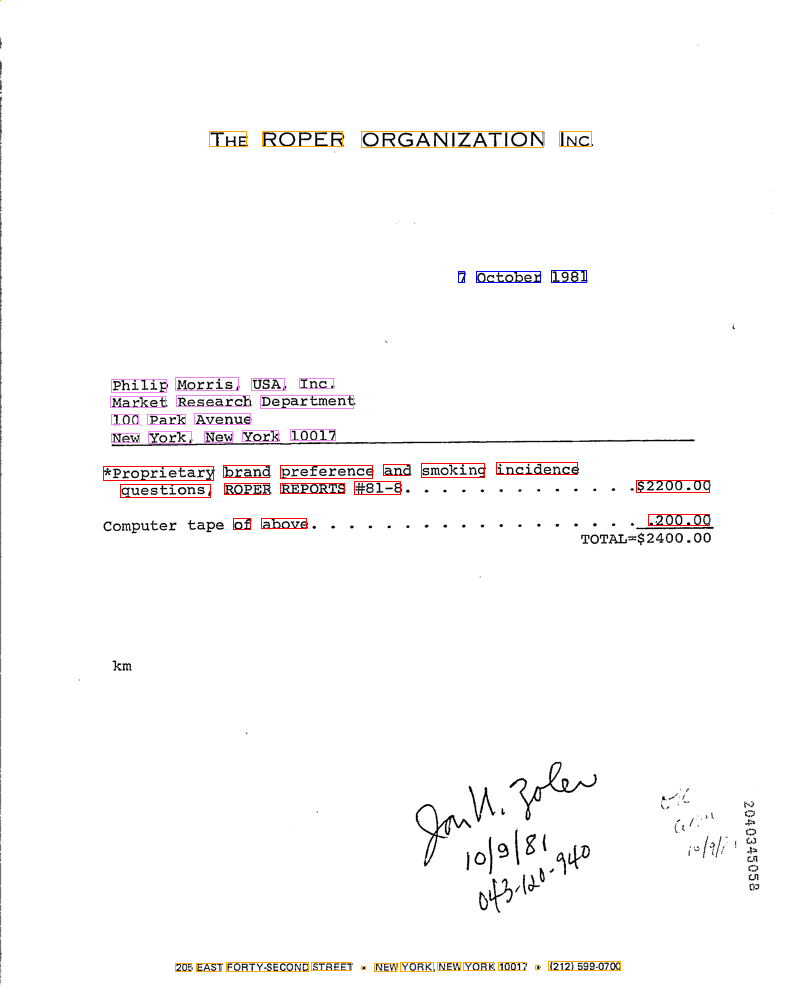

In [ ]:
predict_df = valid.iloc[4:5, :].reset_index(drop = True)
pred_dataset = InvoiceDataSet(df = predict_df, tokenizer = tokenizer, max_length = 512, target_size = 224, train=False)
pred_dataloader = DataLoader(pred_dataset, batch_size=4)
result = predict(pred_dataloader, model)  
imageFilename = os.path.join("/content/gdrive/MyDrive/Colab Notebooks/Proa-ML/Demo-Day/ImageAndXML_Data", predict_df["imageFilename"][0])
image = Image.open(imageFilename)
image = image.convert('RGB')
draw_image(image, pd.DataFrame(result))